# Langchain Agents

## Function Calling with OpenAI

- OpenAI has fine-tuned the `gpt-3.5-turbo-0613` and `gpt-4-0613` models to:
    - Access additional arguments through which users can pass in descriptions of functions.
    - If it is relevant, return the name of the function to use, along with a JSON object with the appropriate input parameters.

In [1]:
import os
from getpass import getpass

import openai

In [2]:
os.environ['OPENAI_API_KEY'] = getpass()

 ········


In [3]:
import json

def get_current_weather(location, unit='fahrenheit'):
    """Get the current weather in a given location"""
    weather_info = {
        "location": location, 
        "temperature": "72", 
        "unit": unit, 
        "forecast": ["sunny", "windy"], 
    }
    return json.dumps(weather_info)

In [4]:
# Define a function
functions = [
    {
        "name": "get_current_weather", 
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object", 
            "properties": {
                "location": {
                    "type": "string", 
                    "description": "The city and the state"
                }, 
                "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]}
            }, 
            "required": ["location"]
        },
    }
]

In [5]:
messages = [
    {
        "role": "user", 
        "content": "What's the weather like in Bengaluru?"
    }
]

In [6]:
# Call OpenAI Completions
from openai import OpenAI
client = OpenAI()
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125", 
    messages=messages, 
    functions=functions
)

In [7]:
print(response)

ChatCompletion(id='chatcmpl-9bip53w8T9vlFPwTag4gfyUn3uiKS', choices=[Choice(finish_reason='function_call', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=FunctionCall(arguments='{"location":"Bengaluru"}', name='get_current_weather'), tool_calls=None))], created=1718777463, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=18, prompt_tokens=76, total_tokens=94))


In [8]:
response_message = response.choices[0].message
response_message

ChatCompletionMessage(content=None, role='assistant', function_call=FunctionCall(arguments='{"location":"Bengaluru"}', name='get_current_weather'), tool_calls=None)

In [9]:
response_message.content

In [10]:
args = json.loads(response_message.function_call.arguments)
args

{'location': 'Bengaluru'}

In [11]:
get_current_weather(args)

'{"location": {"location": "Bengaluru"}, "temperature": "72", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}'

In [12]:
messages = [
    {
        "role": "user", 
        "content": "hi"
    }
]
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125", 
    messages=messages, 
    functions=functions, 
    function_call="auto"
)
print(response)

ChatCompletion(id='chatcmpl-9bip83jFi7kogRxah9crap53jjsqM', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', role='assistant', function_call=None, tool_calls=None))], created=1718777466, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=10, prompt_tokens=68, total_tokens=78))


## LangChain Expression Language(LCEL)

- LangChain composes chains of components.
- LCEL and the runnable protocol define:
    - An allowed set of input types.
    - Required Methods: `invoke`, `stream`, `batch`, etc.
    - Output types
- Composition can use the Linux Pipe syntax: `Chain = prompt | llm | OutputParser`
- Components implement **Runnable** protocol.
- Common methods include:
    - `invoke [ainvoke]`
    - `stream [astream]`
    - `batch [abatch]`
- Common Properties
    - `input_schema`
    - `output_schema`
- Common I/O
  
  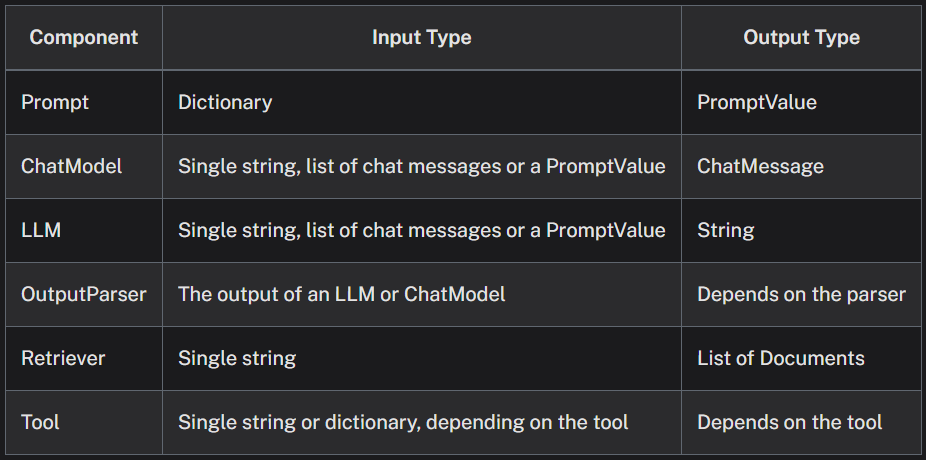

- **Runnables Support**
    - Async, Batch and Streaming Support
    - Fallbacks
    - Parallelism
        - LLM Calls can be time consuming
        - Any components that can be run in parallel are.
    - Logging is built in

In [13]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

In [14]:
# Create a Prompt
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [15]:
chain = prompt | model | output_parser

In [16]:
chain.invoke({"topic": "bears"})

'Why did the bear dissolve in water?\n\nBecause it was polar!'

In [17]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [18]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["except love, everything is physics", "Every day, when we wake up, we open our eyes and see"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [19]:
retriever.get_relevant_documents("what we do when we wake up?")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='Every day, when we wake up, we open our eyes and see'),
 Document(page_content='except love, everything is physics')]

In [20]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [21]:
from langchain.schema.runnable import RunnableMap

In [22]:
input_runnable = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]), 
    "question": lambda x: x["question"]
})

In [23]:
chain = input_runnable | prompt | model | output_parser

In [24]:
chain.invoke({"question": "what we do when we wake up?"})

'When we wake up, we open our eyes and see.'

## OpenAI Function Calling in LangChain

### Pydantic

- Pydantic is a data validation library for python.
- Works with python type annotations. But rather than static type checking, they are actively used at runtime for data validation and conversion.
- Provides built-in methods to serialize/deserialize models to/from JSON, dict, etc.
- LangChain leverages pydantic to create JSON Scheme describing function.

```
Normal Python(Without Pydantic)

class User:
    def __init__(self, name: str, age: int, email: str):
        self.name = self.name
        self.age = age
        self.email = email

Using Pydantic

from pydantic import BaseModel

class User(BaseModel):
    name: str
    age: int
    email: EmailStr
```

In [25]:
from typing import List
from pydantic import BaseModel, Field

In [26]:
class User:
    def __init__(self, name: str, age: int, email: str):
        self.name = name
        self.age = age
        self.email = email

In [27]:
foo = User(name="Joe",age=32, email="joe@gmail.com")

In [28]:
foo.name

'Joe'

In [29]:
foo = User(name="Joe",age="bar", email="joe@gmail.com")

In [30]:
foo.age

'bar'

In [31]:
class pUser(BaseModel):
    name: str
    age: int
    email: str

In [32]:
foo_p = pUser(name="Jane", age=32, email="jane@gmail.com")

In [33]:
foo_p.name

'Jane'

In [34]:
foo_p = pUser(name="Jane", age="bar", email="jane@gmail.com")

ValidationError: 1 validation error for pUser
age
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='bar', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/int_parsing

In [35]:
class Class(BaseModel):
    students: List[pUser]

In [36]:
obj = Class(
    students=[pUser(name="Jane", age=32, email="jane@gmail.com")]
)

In [37]:
obj

Class(students=[pUser(name='Jane', age=32, email='jane@gmail.com')])

In [38]:
class WeatherSearch(BaseModel):
    """Call this with an airport code to get the weather at that airport"""
    airport_code: str = Field(description="airport code to get weather for")

In [39]:
from langchain.utils.openai_functions import convert_pydantic_to_openai_function

In [40]:
weather_function = convert_pydantic_to_openai_function(WeatherSearch)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `convert_pydantic_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [41]:
weather_function

{'name': 'WeatherSearch',
 'description': 'Call this with an airport code to get the weather at that airport',
 'parameters': {'properties': {'airport_code': {'description': 'airport code to get weather for',
    'type': 'string'}},
  'required': ['airport_code'],
  'type': 'object'}}

In [44]:
from langchain.chat_models import ChatOpenAI

In [45]:
model = ChatOpenAI()

In [46]:
model.invoke("what is the weather in SF today?", functions=[weather_function])

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-1b2c1b99-8150-4a1a-a4a0-c384c12d7280-0')

In [47]:
model_with_function = model.bind(functions=[weather_function])

In [48]:
model_with_function.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 69, 'total_tokens': 86}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-6cd9b3ab-b1e7-49f7-8230-361faa51c29a-0')

In [50]:
model_with_forced_function = model.bind(functions=[weather_function], function_call={"name":"WeatherSearch"})
model_with_forced_function.invoke("what is the weather in sf?")
model_with_forced_function.invoke("hi!")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"JFK"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 74, 'total_tokens': 81}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-1247fa5b-8461-4333-b9fa-1b89e040c60d-0')

In [51]:
from langchain.prompts import ChatPromptTemplate

In [52]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant"),
    ("user", "{input}")
])

In [53]:
chain = prompt | model_with_function

In [54]:
chain.invoke({"input": "what is the weather in sf?"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 75, 'total_tokens': 92}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-fe378431-0e7f-481f-b55e-1afabb06aab9-0')

In [55]:
class ArtistSearch(BaseModel):
    """Call this to get the names of songs by a particular artist"""
    artist_name: str = Field(description="name of artist to look up")
    n: int = Field(description="number of results")

In [56]:
functions = [
    convert_pydantic_to_openai_function(WeatherSearch),
    convert_pydantic_to_openai_function(ArtistSearch),
]

In [57]:
model_with_functions = model.bind(functions=functions)

In [58]:
model_with_functions.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 116, 'total_tokens': 133}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-8a1ec9ee-288b-4755-a36e-8dd75ec50196-0')

In [59]:
model_with_functions.invoke("what are three songs by taylor swift?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"artist_name":"Taylor Swift","n":3}', 'name': 'ArtistSearch'}}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 118, 'total_tokens': 139}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-0cec3dbc-c0bb-4a73-9dff-b062df47f518-0')

In [60]:
model_with_functions.invoke("hi!")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 111, 'total_tokens': 121}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-453118ae-feb7-476d-ad2a-b8753ad855dd-0')

## Tagging And Extraction

In [61]:
class Tagging(BaseModel):
    """Tag the piece of text with particular info."""
    sentiment: str = Field(description="sentiment of text, should be `pos`, `neg`, or `neutral`")
    language: str = Field(description="language of text (should be ISO 639-1 code)")